In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [3]:
# Load image dataset with training and validation split
def load_dataset(data_dir, img_height=224, img_width=224, batch_size=32):
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'), tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary')

In [4]:
base_dir = 'dataset/'
train_ds, val_ds = load_dataset(base_dir)

Found 2693 files belonging to 2 classes.
Using 2155 files for training.
Found 2693 files belonging to 2 classes.
Using 538 files for validation.


In [5]:
# Pre-process the input images
def preprocess_input(image, label):
    return tf.keras.applications.inception_resnet_v2.preprocess_input(image), label

In [6]:
# Preprocess and configure datasets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(preprocess_input).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess_input).cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# CNN model
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
# InceptionV3 model
def create_inception_model():
    base_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
# Inception-ResNet-V2 model
def create_inception_resnet_v2_model():
    base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224, 224, 3),
                                                         include_top=False,
                                                         weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [10]:
# Initialize models
cnn_model = create_cnn_model()
inception_model = create_inception_model()
inception_resnet_v2_model = create_inception_resnet_v2_model()

In [11]:
# Compile models with additional metrics
metrics = [
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')  # Precision-recall curve
]

In [12]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
inception_resnet_v2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [13]:
# Train models
history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10)
history_inception = inception_model.fit(train_ds, validation_data=val_ds, epochs=10)
history_inception_resnet_v2 = inception_resnet_v2_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
68/68 [==============================] - 69s 797ms/step - loss: 0.6383 - accuracy: 0.9281 - precision: 0.9219 - recall: 0.9131 - auc: 0.9619 - prc: 0.9367 - val_loss: 0.0011 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 2/10
68/68 [==============================] - 41s 607ms/step - loss: 3.2246e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0275e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/10
68/68 [==============================] - 39s 580ms/step - loss: 5.2152e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 5.9801e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 4/10
68/68 [==============================] - 39s 570ms/step - loss: 2.8358e-05 - accuracy: 1.0000 - precision:

In [14]:
# Plotting function for training history for each metric
def plot_history(histories, keys=('accuracy', 'precision', 'recall', 'auc', 'prc')):
    for key in keys:
        plt.figure(figsize=(12, 8))
        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_' + key],
                           '--', label=name.title() + ' Val')
            plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                     label=name.title() + ' Train')

        plt.title('Model Performance: ' + key)
        plt.xlabel('Epochs')
        plt.ylabel(key.capitalize())
        plt.legend()
        plt.xlim([0, max(history.epoch)])
        plt.show()

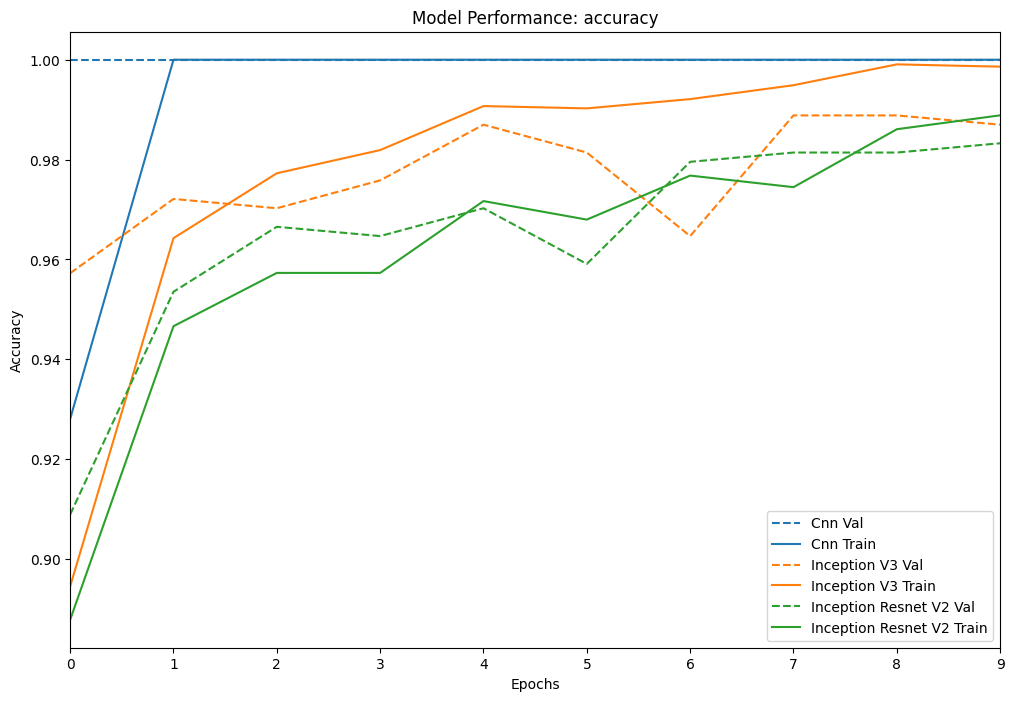

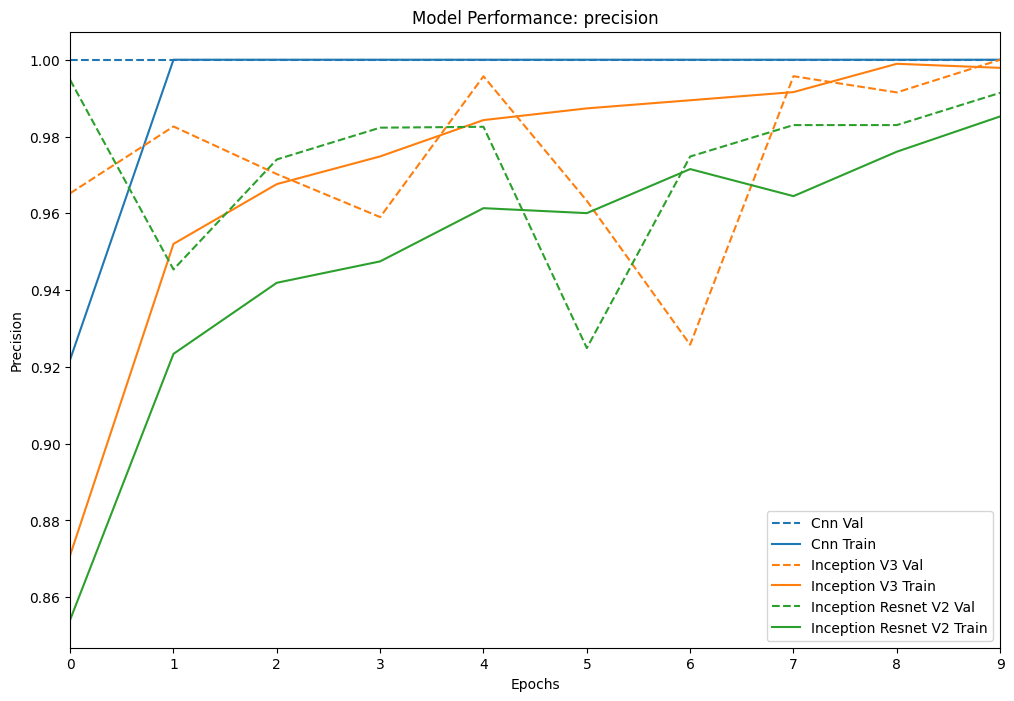

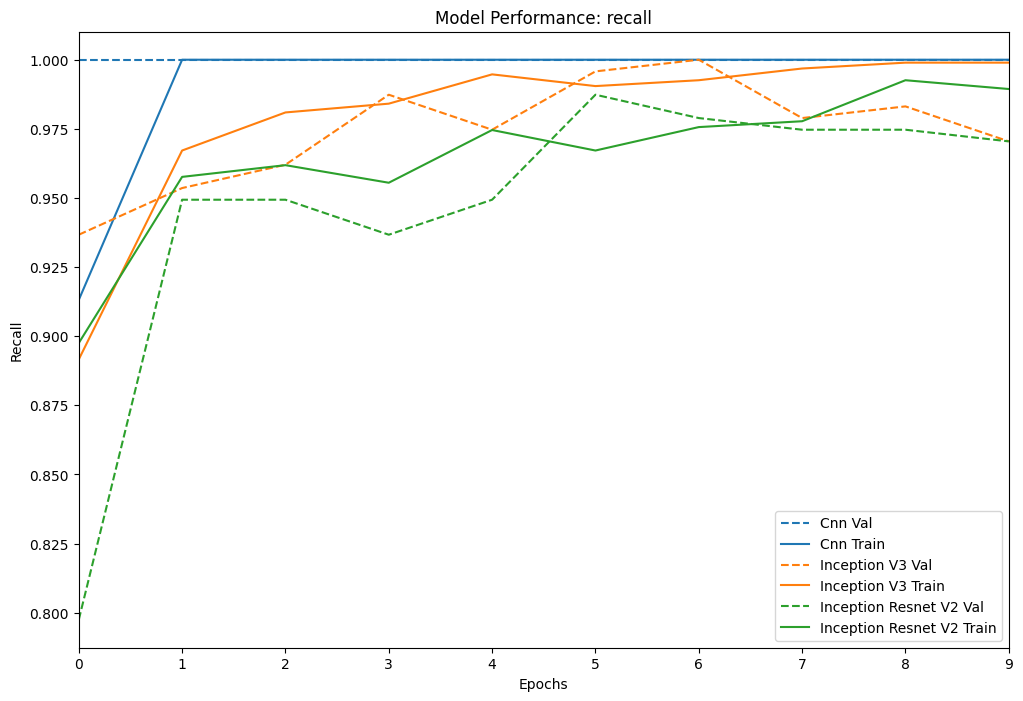

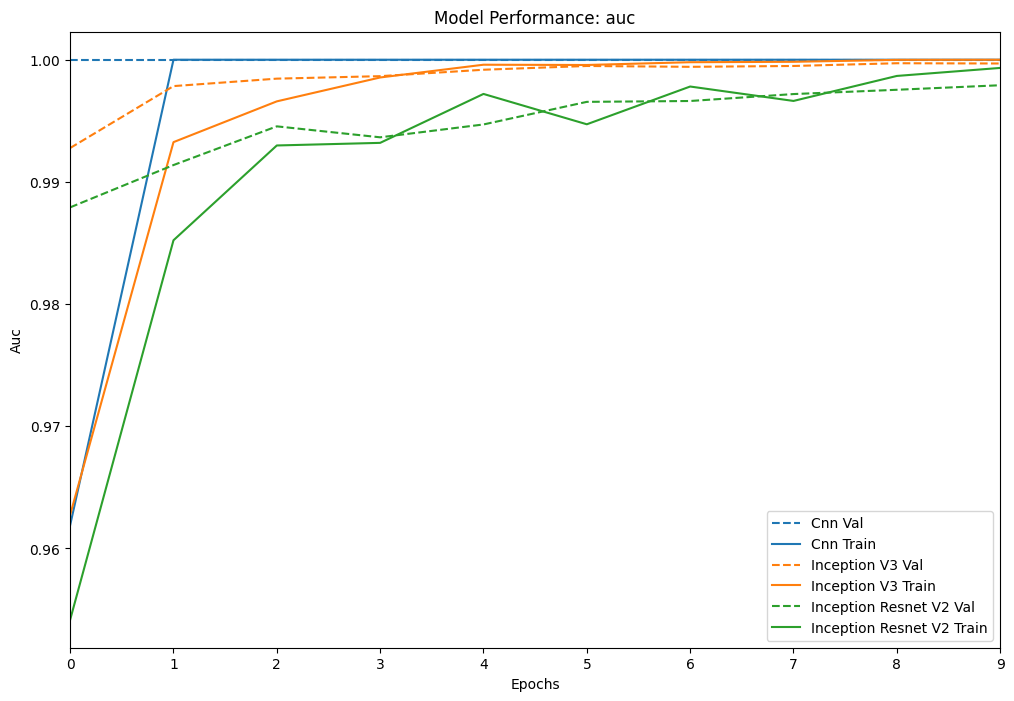

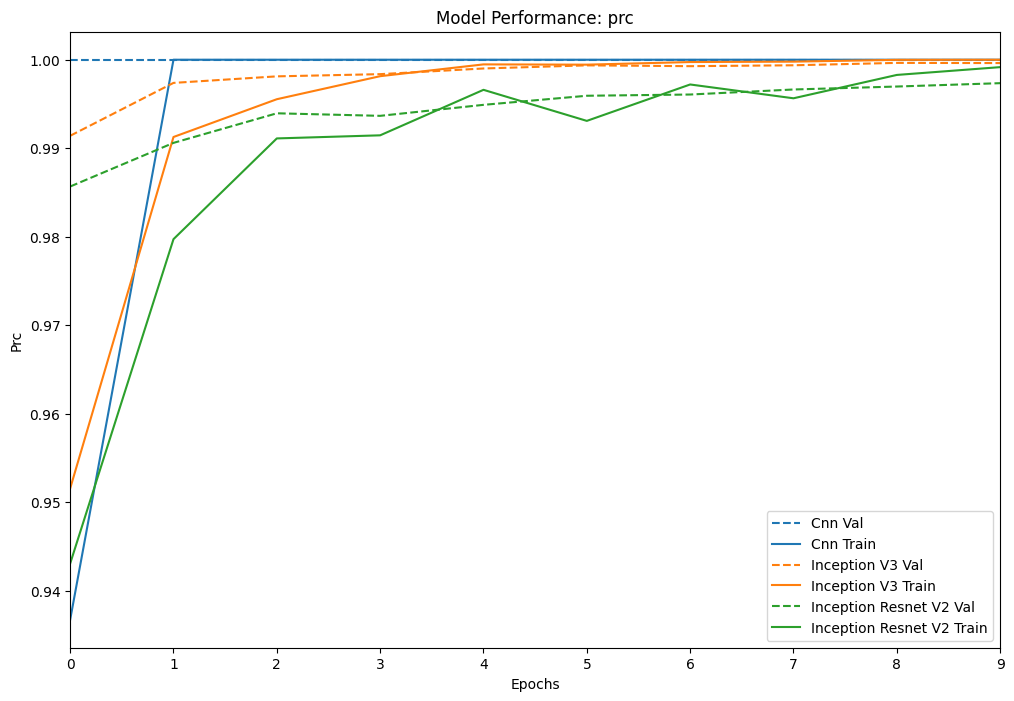

In [15]:
# Execute plotting
plot_history([
    ('CNN', history_cnn),
    ('Inception V3', history_inception),
    ('Inception ResNet V2', history_inception_resnet_v2)
])